In [2]:
# checking the GPU type for Tesla T4
!nvidia-smi

Tue Apr 19 09:18:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   24C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [79]:
# start some coding

import cudf
import cuml

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

In [112]:
url = "https://raw.githubusercontent.com/BUCKERS99/C7084-Big-data--Will-it-rain-tomorrow-/main/weather_data.csv"
df = cudf.read_csv(url)
# print(c)

In [113]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Date           145460 non-null  object
 1   Location       145460 non-null  object
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object
 10  WindDir3pm     141232 non-null  object
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null   floa

In [114]:
# separate the model features and target
model_features = df.columns.drop(['RainTomorrow','Date'])
model_target = 'RainTomorrow'

print('Model features: ', model_features)
print('Model target: ', model_target)

Model features:  Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')
Model target:  RainTomorrow


In [115]:
df_NA = df.dropna(subset=["RainTomorrow"])

In [116]:
df_NA['RainTomorrow'] = df_NA['RainTomorrow'].astype('category')
df_NA['RainToday'] = df_NA['RainToday'].astype('category')
df_NA['WindGustDir'] = df_NA['WindGustDir'].astype('category')
df_NA['WindDir9am'] = df_NA['WindDir9am'].astype('category')
df_NA['WindDir3pm'] = df_NA['WindDir3pm'].astype('category')
df_NA['Location'] = df_NA['Location'].astype('category')
df_NA['Date'] = df_NA['Date'].astype('category')

In [117]:
df_NA.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Date           142193 non-null  category
 1   Location       142193 non-null  category
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  category
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  category
 10  WindDir3pm     138415 non-null  category
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-n

In [118]:
df_NA = df_NA.dropna()
df_NA.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Date           56420 non-null  category
 1   Location       56420 non-null  category
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  category
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  category
 10  WindDir3pm     56420 non-null  category
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18 

In [119]:
# categorical variables need encoding

In [120]:
df_NA['WindGustDir'] = df_NA.WindGustDir.cat.codes
codes = df_NA.WindGustDir.unique()
enc_df = df_NA.one_hot_encoding('WindGustDir', 'WindGustDir_codes', codes)

In [121]:
df_NA['WindDir9am'] = df_NA.WindDir9am.cat.codes
codes = df_NA.WindDir9am.unique()
enc_df = df_NA.one_hot_encoding('WindDir9am', 'WindDir9am_codes', codes)

In [122]:
df_NA['WindDir3pm'] = df_NA.WindDir3pm.cat.codes
codes = df_NA.WindDir3pm.unique()
enc_df = df_NA.one_hot_encoding('WindDir3pm', 'WindDir3pm_codes', codes)

In [123]:
df_NA['RainTomorrow'] = df_NA.RainTomorrow.cat.codes
codes = df_NA.RainTomorrow.unique()
enc_df = df_NA.one_hot_encoding('RainTomorrow', 'RainTomorrow_codes', codes)

In [124]:
df_NA['RainToday'] = df_NA.RainToday.cat.codes
codes = df_NA.RainToday.unique()
enc_df = df_NA.one_hot_encoding('RainToday', 'RainToday_codes', codes)

In [125]:
df_NA['Date'] = df_NA.Date.cat.codes
codes = df_NA.Date.unique()
enc_df = df_NA.one_hot_encoding('Date', 'Date_codes', codes)

In [126]:
df_NA['Location'] = df_NA.Location.cat.codes
codes = df_NA.Location.unique()
enc_df = df_NA.one_hot_encoding('Location', 'Location_codes', codes)

In [141]:
import time
start = time.time()

from cuml import make_regression, train_test_split
X_train, X_test, y_train, y_test  = cuml.train_test_split(df_NA[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']], df_NA['RainTomorrow'], train_size=0.8)

print(f'Time: {time.time() - start}')

Time: 0.014074563980102539


In [128]:
X_test.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 11284 entries, 33832 to 21671
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MinTemp        11284 non-null  float64
 1   MaxTemp        11284 non-null  float64
 2   Rainfall       11284 non-null  float64
 3   Evaporation    11284 non-null  float64
 4   Sunshine       11284 non-null  float64
 5   WindGustDir    11284 non-null  uint8
 6   WindGustSpeed  11284 non-null  float64
 7   WindDir9am     11284 non-null  uint8
 8   WindDir3pm     11284 non-null  uint8
 9   WindSpeed9am   11284 non-null  float64
 10  WindSpeed3pm   11284 non-null  float64
 11  Humidity9am    11284 non-null  float64
 12  Humidity3pm    11284 non-null  float64
 13  Pressure9am    11284 non-null  float64
 14  Pressure3pm    11284 non-null  float64
 15  Cloud9am       11284 non-null  float64
 16  Cloud3pm       11284 non-null  float64
 17  Temp9am        11284 non-null  float64
 18  Temp3pm   

In [129]:
X_train.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 45136 entries, 118055 to 132111
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MinTemp        45136 non-null  float64
 1   MaxTemp        45136 non-null  float64
 2   Rainfall       45136 non-null  float64
 3   Evaporation    45136 non-null  float64
 4   Sunshine       45136 non-null  float64
 5   WindGustDir    45136 non-null  uint8
 6   WindGustSpeed  45136 non-null  float64
 7   WindDir9am     45136 non-null  uint8
 8   WindDir3pm     45136 non-null  uint8
 9   WindSpeed9am   45136 non-null  float64
 10  WindSpeed3pm   45136 non-null  float64
 11  Humidity9am    45136 non-null  float64
 12  Humidity3pm    45136 non-null  float64
 13  Pressure9am    45136 non-null  float64
 14  Pressure3pm    45136 non-null  float64
 15  Cloud9am       45136 non-null  float64
 16  Cloud3pm       45136 non-null  float64
 17  Temp9am        45136 non-null  float64
 18  Temp3pm 

In [131]:
from cuml.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [132]:
start = time.time()

knn.fit(X_train, y_train)

print(f'time: {time.time() - start}')

time: 0.008864402770996094


In [133]:
start = time.time()

y_test_pred = knn.predict(X_test)
y_test_pred.index = X_test.index
print(y_test_pred.tail())

print(f'Time: {time.time() - start}')

93531     0
34730     0
105720    0
89341     0
21671     0
dtype: uint8
Time: 0.19739031791687012


In [135]:
#Train accuracy
from cuml.metrics import accuracy_score
start = time.time()

train_pred = knn.predict(X_train)

print("Training accuracy:", accuracy_score(y_train, train_pred))

print(f'Time: {time.time() - start}')

Training accuracy: 0.8620613217353821
Time: 0.2818024158477783


In [139]:
# Test Accuracy - this line changes something and prevents the validation step from running?
test_results = cudf.DataFrame()
test_results = X_test
test_results['RainTomorrow'] = y_test

In [75]:
from cuml.metrics import accuracy_score

print("Test accuracy:", accuracy_score(y_test, y_test_pred))

Test accuracy: 0.8425203561782837


In [76]:
ddf = X_test.copy()

ddf['actual'] = y_test.values
ddf['predicted'] = y_test_pred.values
ddf.tail

<bound method DataFrame.tail of         MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
14362       5.1     12.3       8.0         11.4       0.5           13   
61214      18.5     24.6       0.2          1.6       0.1            9   
136258     11.4     19.7       1.2          4.8      10.3           12   
71927      11.3     15.4       6.2          1.0       0.1           13   
37740       5.3     11.8       2.8          0.6       0.0           14   
...         ...      ...       ...          ...       ...          ...   
46708      11.7     26.1       0.0          6.0       4.5            7   
93450      15.7     28.6       0.0          4.6       9.7            3   
141372     24.5     33.5      25.4          9.4       7.1            7   
61399       5.3     19.0       0.0          2.0       0.7            3   
62583      11.1     22.4       0.0         12.0      13.1            0   

        WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  ...  Pressure9am  

In [71]:
n_correct = len(ddf.loc[ddf['actual'] == ddf['predicted']])
n_possible = len(ddf)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible)[:17]}% accuracy')

9507 / 11284 correct
0.842520382842963% accuracy


In [72]:
# the model gave the correct outcome 9534/11284 times with 84% accuracy

In [ ]:
# For some reason getting the test accuracy changes somehting within X_test and then the validation throws an error. A workaround of repeating the test/train splitting al;lowed for the cross validation step to be run. 
# This is acceptable as we are more looking at the time to completion

In [143]:
import time
start = time.time()

from cuml import make_regression, train_test_split
X_train, X_test, y_train, y_test  = cuml.train_test_split(df_NA[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']], df_NA['RainTomorrow'], train_size=0.8)

print(f'Time: {time.time() - start}')

Time: 0.014655590057373047


In [144]:
# choose k between 1 to 31
start = time.time()

k_range = range(1, 31)
scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    
print(scores)
print(f'Time: {time.time() - start}')

[0.807692289352417, 0.8293158411979675, 0.8328607082366943, 0.8397731184959412, 0.8403934836387634, 0.8448245525360107, 0.8437610864639282, 0.8486352562904358, 0.8482807278633118, 0.8493441939353943, 0.8478376269340515, 0.848901093006134, 0.8483693599700928, 0.849166989326477, 0.849078357219696, 0.8503190279006958, 0.8509393930435181, 0.8497872948646545, 0.8520914316177368, 0.8502303957939148, 0.8514711260795593, 0.8513824939727783, 0.8502303957939148, 0.8504076600074768, 0.8518255949020386, 0.8522686958312988, 0.8527117967605591, 0.8518255949020386, 0.8529776930809021, 0.8527117967605591]
Time: 6.114320993423462


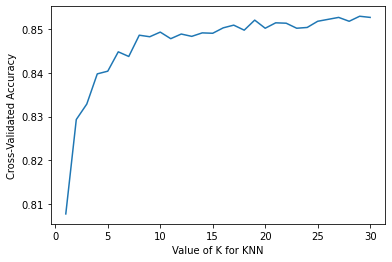

Time: 0.10926055908203125


In [145]:
start = time.time()

# plot to see clearly
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()


print(f'Time: {time.time() - start}')